In [1]:
import warnings
warnings.filterwarnings("ignore")

from transformers import BartTokenizer, BartForConditionalGeneration, Trainer, TrainingArguments
import torch
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset
import matplotlib.pyplot as plt

In [2]:
# Load dataset
data = pd.read_csv('Customer-Support.csv')
data

,query,response
0,My order hasn't arrived yet.,We apologize for the inconvenience. Can you pl...
1,I received a damaged product.,We apologize for the inconvenience. Can you pl...
2,I need to return an item.,Certainly. Please provide your order number an...
3,I want to change my shipping address.,No problem. Can you please provide your order ...
4,I have a question about my bill.,We'd be happy to help. Can you please provide ...
...,...,...
69,How do I schedule a consultation or appointment?,We'd be happy to help. Can you please provide ...
70,Can I get a copy of my receipt?,Certainly. Can you please provide your order n...
71,Can I use a competitor's coupon at your store?,"In some cases, we may accept competitor coupon..."
72,Do you have a recycling program?,"Yes, we do have a recycling program. Can you p..."


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74 entries, 0 to 73
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   query     74 non-null     object
 1   response  74 non-null     object
dtypes: object(2)
memory usage: 1.3+ KB


In [4]:
# Concatenate query and response with a special token
df = pd.DataFrame()
df['input_text'] = data['query'] + " [SEP] "  # If you intend to use the response as the target
df['target_text'] = data['response']
df

,input_text,target_text
0,My order hasn't arrived yet. [SEP],We apologize for the inconvenience. Can you pl...
1,I received a damaged product. [SEP],We apologize for the inconvenience. Can you pl...
2,I need to return an item. [SEP],Certainly. Please provide your order number an...
3,I want to change my shipping address. [SEP],No problem. Can you please provide your order ...
4,I have a question about my bill. [SEP],We'd be happy to help. Can you please provide ...
...,...,...
69,How do I schedule a consultation or appointmen...,We'd be happy to help. Can you please provide ...
70,Can I get a copy of my receipt? [SEP],Certainly. Can you please provide your order n...
71,Can I use a competitor's coupon at your store?...,"In some cases, we may accept competitor coupon..."
72,Do you have a recycling program? [SEP],"Yes, we do have a recycling program. Can you p..."


In [5]:
# Function to calculate word count
def count_words(text):
    words = text.split()
    return len(words)

# Calculate word counts for each row
df['word_count_input'] = df['input_text'].apply(count_words)
df['word_count_target'] = df['target_text'].apply(count_words)

# Get statistics: max, min, percentiles
word_counts = df[['word_count_input', 'word_count_target']].values.flatten()

max_word_count = np.max(word_counts)
min_word_count = np.min(word_counts)
percentiles = np.percentile(word_counts, [25, 50, 75, 90])

print(f"Maximum word count: {max_word_count}")
print(f"Minimum word count: {min_word_count}")
print(f"25th percentile word count: {percentiles[0]}")
print(f"50th percentile word count (median): {percentiles[1]}")
print(f"75th percentile word count: {percentiles[2]}")
print(f"90th percentile word count: {percentiles[3]}")

Maximum word count: 32
Minimum word count: 5
25th percentile word count: 8.0
50th percentile word count (median): 14.0
75th percentile word count: 23.0
90th percentile word count: 26.0


In [6]:
# Initialize tokenizer
tokenizer = BartTokenizer.from_pretrained('facebook/bart-large')

# Tokenize the data
def tokenize_function(texts, labels=None):
    encodings = tokenizer(texts.tolist(), padding=True, truncation=True, return_tensors="pt")
    if labels is not None:
        label_encodings = tokenizer(labels.tolist(), padding=True, truncation=True, return_tensors="pt")
        encodings['labels'] = label_encodings['input_ids']
        # Create a mask for the pad token and set them to -100
        encodings['labels'][encodings['labels'] == tokenizer.pad_token_id] = 50
    return encodings

train_data, val_data = train_test_split(df[['input_text', 'target_text']], test_size=0.1, random_state=42)

train_encodings = tokenize_function(train_data['input_text'], train_data['target_text'])
val_encodings = tokenize_function(val_data['input_text'], val_data['target_text'])

class CustomDataset(Dataset):
    def __init__(self, encodings):
        self.encodings = encodings

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        return item

    def __len__(self):
        return len(self.encodings['input_ids'])

train_dataset = CustomDataset(train_encodings)
val_dataset = CustomDataset(val_encodings)

In [8]:
# Load model and move to GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = BartForConditionalGeneration.from_pretrained('facebook/bart-large').to(device)

# Training arguments
training_args = TrainingArguments(
    num_train_epochs=20,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    warmup_steps=500,
    weight_decay=0.01,
    logging_steps=10,
    evaluation_strategy="steps",
    save_steps=10_000,
    save_total_limit=2,
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    output_dir='./results',
    logging_dir='./logs',
)

# Initialize Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
)

trainer.train()

  0%|          | 0/340 [00:00<?, ?it/s]

{'loss': 10.3222, 'learning_rate': 1.0000000000000002e-06, 'epoch': 0.59}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 9.707420349121094, 'eval_runtime': 0.1476, 'eval_samples_per_second': 54.203, 'eval_steps_per_second': 13.551, 'epoch': 0.59}
{'loss': 7.9468, 'learning_rate': 2.0000000000000003e-06, 'epoch': 1.18}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 5.919564247131348, 'eval_runtime': 0.088, 'eval_samples_per_second': 90.889, 'eval_steps_per_second': 22.722, 'epoch': 1.18}
{'loss': 5.3332, 'learning_rate': 3e-06, 'epoch': 1.76}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 3.590090751647949, 'eval_runtime': 0.108, 'eval_samples_per_second': 74.058, 'eval_steps_per_second': 18.514, 'epoch': 1.76}
{'loss': 3.2732, 'learning_rate': 4.000000000000001e-06, 'epoch': 2.35}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 2.392101287841797, 'eval_runtime': 0.095, 'eval_samples_per_second': 84.192, 'eval_steps_per_second': 21.048, 'epoch': 2.35}
{'loss': 2.2921, 'learning_rate': 5e-06, 'epoch': 2.94}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 1.528806447982788, 'eval_runtime': 0.092, 'eval_samples_per_second': 86.938, 'eval_steps_per_second': 21.735, 'epoch': 2.94}
{'loss': 1.6109, 'learning_rate': 6e-06, 'epoch': 3.53}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 1.1531431674957275, 'eval_runtime': 0.115, 'eval_samples_per_second': 69.55, 'eval_steps_per_second': 17.387, 'epoch': 3.53}
{'loss': 1.1201, 'learning_rate': 7.000000000000001e-06, 'epoch': 4.12}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.869480311870575, 'eval_runtime': 0.091, 'eval_samples_per_second': 87.893, 'eval_steps_per_second': 21.973, 'epoch': 4.12}
{'loss': 0.8991, 'learning_rate': 8.000000000000001e-06, 'epoch': 4.71}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.7612009644508362, 'eval_runtime': 0.091, 'eval_samples_per_second': 87.893, 'eval_steps_per_second': 21.973, 'epoch': 4.71}
{'loss': 1.0374, 'learning_rate': 9e-06, 'epoch': 5.29}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.7286381721496582, 'eval_runtime': 0.102, 'eval_samples_per_second': 78.413, 'eval_steps_per_second': 19.603, 'epoch': 5.29}
{'loss': 0.7932, 'learning_rate': 1e-05, 'epoch': 5.88}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.7418538331985474, 'eval_runtime': 0.105, 'eval_samples_per_second': 76.173, 'eval_steps_per_second': 19.043, 'epoch': 5.88}
{'loss': 0.8125, 'learning_rate': 1.1000000000000001e-05, 'epoch': 6.47}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.6999688148498535, 'eval_runtime': 0.099, 'eval_samples_per_second': 80.789, 'eval_steps_per_second': 20.197, 'epoch': 6.47}
{'loss': 0.5396, 'learning_rate': 1.2e-05, 'epoch': 7.06}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.6717108488082886, 'eval_runtime': 0.091, 'eval_samples_per_second': 87.892, 'eval_steps_per_second': 21.973, 'epoch': 7.06}
{'loss': 0.5073, 'learning_rate': 1.3000000000000001e-05, 'epoch': 7.65}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.7354111671447754, 'eval_runtime': 0.099, 'eval_samples_per_second': 80.789, 'eval_steps_per_second': 20.197, 'epoch': 7.65}
{'loss': 0.5265, 'learning_rate': 1.4000000000000001e-05, 'epoch': 8.24}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.663489580154419, 'eval_runtime': 0.092, 'eval_samples_per_second': 86.936, 'eval_steps_per_second': 21.734, 'epoch': 8.24}
{'loss': 0.4612, 'learning_rate': 1.5e-05, 'epoch': 8.82}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.6804887056350708, 'eval_runtime': 0.097, 'eval_samples_per_second': 82.456, 'eval_steps_per_second': 20.614, 'epoch': 8.82}
{'loss': 0.4879, 'learning_rate': 1.6000000000000003e-05, 'epoch': 9.41}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.6822841167449951, 'eval_runtime': 0.098, 'eval_samples_per_second': 81.614, 'eval_steps_per_second': 20.404, 'epoch': 9.41}
{'loss': 0.4312, 'learning_rate': 1.7000000000000003e-05, 'epoch': 10.0}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.775656521320343, 'eval_runtime': 0.087, 'eval_samples_per_second': 91.934, 'eval_steps_per_second': 22.983, 'epoch': 10.0}
{'loss': 0.3812, 'learning_rate': 1.8e-05, 'epoch': 10.59}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.7947850227355957, 'eval_runtime': 0.106, 'eval_samples_per_second': 75.455, 'eval_steps_per_second': 18.864, 'epoch': 10.59}
{'loss': 0.333, 'learning_rate': 1.9e-05, 'epoch': 11.18}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.8162636756896973, 'eval_runtime': 0.1, 'eval_samples_per_second': 79.982, 'eval_steps_per_second': 19.995, 'epoch': 11.18}
{'loss': 0.2278, 'learning_rate': 2e-05, 'epoch': 11.76}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.8535722494125366, 'eval_runtime': 0.097, 'eval_samples_per_second': 82.455, 'eval_steps_per_second': 20.614, 'epoch': 11.76}
{'loss': 0.3262, 'learning_rate': 2.1e-05, 'epoch': 12.35}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.8197470903396606, 'eval_runtime': 0.118, 'eval_samples_per_second': 67.781, 'eval_steps_per_second': 16.945, 'epoch': 12.35}
{'loss': 0.2545, 'learning_rate': 2.2000000000000003e-05, 'epoch': 12.94}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.7760680913925171, 'eval_runtime': 0.083, 'eval_samples_per_second': 96.363, 'eval_steps_per_second': 24.091, 'epoch': 12.94}
{'loss': 0.2524, 'learning_rate': 2.3000000000000003e-05, 'epoch': 13.53}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.8457928895950317, 'eval_runtime': 0.089, 'eval_samples_per_second': 89.868, 'eval_steps_per_second': 22.467, 'epoch': 13.53}
{'loss': 0.2304, 'learning_rate': 2.4e-05, 'epoch': 14.12}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.7827653884887695, 'eval_runtime': 0.088, 'eval_samples_per_second': 90.889, 'eval_steps_per_second': 22.722, 'epoch': 14.12}
{'loss': 0.2106, 'learning_rate': 2.5e-05, 'epoch': 14.71}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.9711150527000427, 'eval_runtime': 0.094, 'eval_samples_per_second': 85.089, 'eval_steps_per_second': 21.272, 'epoch': 14.71}
{'loss': 0.1551, 'learning_rate': 2.6000000000000002e-05, 'epoch': 15.29}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.8149964213371277, 'eval_runtime': 0.097, 'eval_samples_per_second': 82.456, 'eval_steps_per_second': 20.614, 'epoch': 15.29}
{'loss': 0.1659, 'learning_rate': 2.7000000000000002e-05, 'epoch': 15.88}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.985166609287262, 'eval_runtime': 0.103, 'eval_samples_per_second': 77.653, 'eval_steps_per_second': 19.413, 'epoch': 15.88}
{'loss': 0.1795, 'learning_rate': 2.8000000000000003e-05, 'epoch': 16.47}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.9106060266494751, 'eval_runtime': 0.103, 'eval_samples_per_second': 77.653, 'eval_steps_per_second': 19.413, 'epoch': 16.47}
{'loss': 0.1488, 'learning_rate': 2.9e-05, 'epoch': 17.06}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.8301354646682739, 'eval_runtime': 0.096, 'eval_samples_per_second': 83.315, 'eval_steps_per_second': 20.829, 'epoch': 17.06}
{'loss': 0.2209, 'learning_rate': 3e-05, 'epoch': 17.65}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.9723851680755615, 'eval_runtime': 0.091, 'eval_samples_per_second': 87.893, 'eval_steps_per_second': 21.973, 'epoch': 17.65}
{'loss': 0.1577, 'learning_rate': 3.1e-05, 'epoch': 18.24}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 1.1979358196258545, 'eval_runtime': 0.096, 'eval_samples_per_second': 83.315, 'eval_steps_per_second': 20.829, 'epoch': 18.24}
{'loss': 0.1959, 'learning_rate': 3.2000000000000005e-05, 'epoch': 18.82}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.9393177032470703, 'eval_runtime': 0.097, 'eval_samples_per_second': 82.456, 'eval_steps_per_second': 20.614, 'epoch': 18.82}
{'loss': 0.1718, 'learning_rate': 3.3e-05, 'epoch': 19.41}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 1.0915284156799316, 'eval_runtime': 0.095, 'eval_samples_per_second': 84.192, 'eval_steps_per_second': 21.048, 'epoch': 19.41}
{'loss': 0.171, 'learning_rate': 3.4000000000000007e-05, 'epoch': 20.0}


  0%|          | 0/2 [00:00<?, ?it/s]

{'eval_loss': 0.8694055676460266, 'eval_runtime': 0.099, 'eval_samples_per_second': 80.791, 'eval_steps_per_second': 20.198, 'epoch': 20.0}
{'train_runtime': 170.5342, 'train_samples_per_second': 7.74, 'train_steps_per_second': 1.994, 'train_loss': 1.240505423265345, 'epoch': 20.0}


TrainOutput(global_step=340, training_loss=1.240505423265345, metrics={'train_runtime': 170.5342, 'train_samples_per_second': 7.74, 'train_steps_per_second': 1.994, 'train_loss': 1.240505423265345, 'epoch': 20.0})

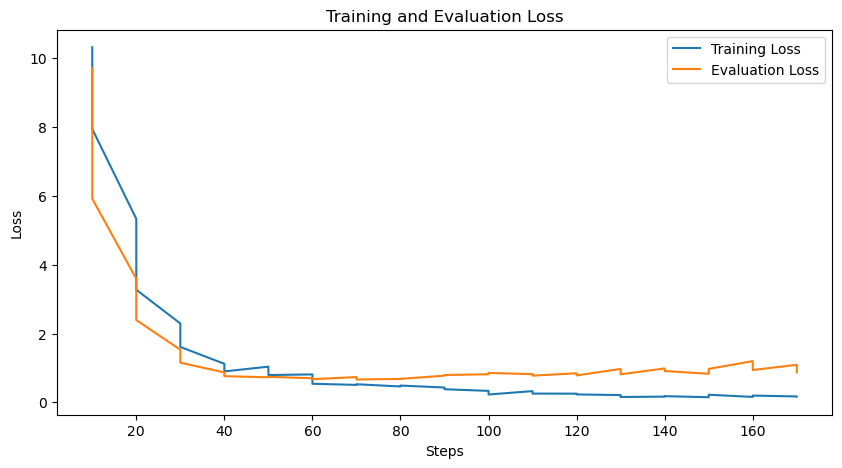

In [12]:
# Extract metrics
metrics = trainer.state.log_history

# Separate training and evaluation metrics
train_loss = [x['loss'] for x in metrics if 'loss' in x.keys()]
eval_loss = [x['eval_loss'] for x in metrics if 'eval_loss' in x.keys()]
steps = [x['step'] for x in metrics if 'step' in x.keys()]

# Ensure steps, train_loss, and eval_loss have the same length
min_length = min(len(steps), len(train_loss), len(eval_loss))
steps = steps[:min_length]
train_loss = train_loss[:min_length]
eval_loss = eval_loss[:min_length]

# Plot training and evaluation loss
plt.figure(figsize=(10, 5))
plt.plot(steps, train_loss, label='Training Loss')
plt.plot(steps, eval_loss, label='Evaluation Loss')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Evaluation Loss')
plt.show()

In [14]:
# Save the final trained model
model_path = "./fine_tuned_bart"
trainer.save_model(model_path)

Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'early_stopping': True, 'num_beams': 4, 'no_repeat_ngram_size': 3, 'forced_bos_token_id': 0, 'forced_eos_token_id': 2}
